# Lec 15. Transfer Learning - ResNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
import torch.utils.data as Data

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Load Data

squirrel / chipmunk classification

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])      # 0 ~ 1 사이로 normalization
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

batch_size = 5

train_data = datasets.ImageFolder('data/squir_chip/train/', train_transform)
test_data = datasets.ImageFolder('data/squir_chip/val', test_transform)

train_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = Data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
print(len(train_data), len(test_data))

144 50


In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (15, 45))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

tensor([0, 1, 1, 1, 1])


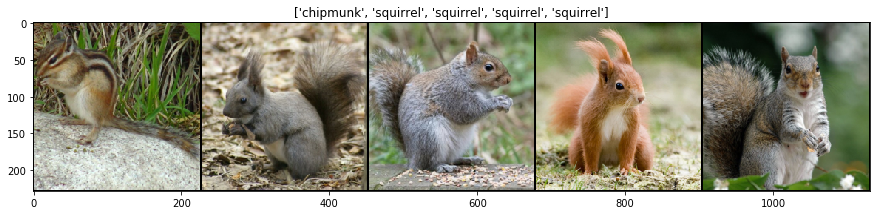

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

imshow(utils.make_grid(images, normalize=True), [train_data.classes[i] for i in labels])

## Define Model

In [8]:
model = models.resnet18(pretrained=True)

model.aux_logits = False
fine_tune = False

if not fine_tune:
    for parameter in model.parameters():
        parameter.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [9]:
loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 10

for epoch in range(num_epochs):

    total_batch = len(train_data)//batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pred = model(X)
        cost = loss(pred, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f' % (epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [28/28] Loss: 0.4241
Epoch [2/10], lter [28/28] Loss: 0.3057
Epoch [3/10], lter [28/28] Loss: 0.5414
Epoch [4/10], lter [28/28] Loss: 0.8723
Epoch [5/10], lter [28/28] Loss: 0.2288
Epoch [6/10], lter [28/28] Loss: 0.2601
Epoch [7/10], lter [28/28] Loss: 0.3323
Epoch [8/10], lter [28/28] Loss: 0.0997
Epoch [9/10], lter [28/28] Loss: 0.0351
Epoch [10/10], lter [28/28] Loss: 0.1934


## 15.3 Test Model

In [11]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * correct / total))

Accuracy of test images: 98.000000 %


In [12]:
classes = ["Chipmunk", "Squirrel"]

Predicted:  Squirrel Squirrel Chipmunk Chipmunk Squirrel


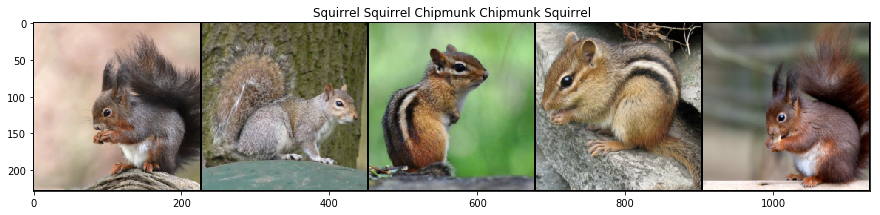

In [13]:
images, labels = iter(test_loader).next()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(utils.make_grid(images, normalize=True), title)

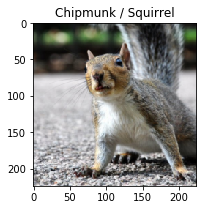

In [14]:
# 테스트 중 틀린 것만 보고 싶은 경우
def imshow_one(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (3, 3))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()
    
for i, (images, labels) in enumerate(test_loader) :
    
    outputs = model(images.cuda())

    _, predicted = torch.max(outputs.data, 1)

    for k in range(5):
        if predicted[k].cpu() != labels[k]:
            imshow_one(utils.make_grid(images[k], normalize=True), classes[predicted[k]] + " / " + classes[labels[k]])
